Welcome to the most interesting part of the application.
I am super excited to present the solutions which I have come up. The major part of the optimization problem is inspired by the following of research papers:

Top_Dutch_Racing -> https://drive.google.com/file/d/1pi5htZ5d31se_-CyicMIDMoONRvfLpqB/view?usp=sharing


Genetic_method_bwsc -> https://drive.google.com/file/d/1i3_GyJ0OTlXOpLaQLOUSgEJeTV6vbPL_/view?usp=sharing

Strategy_for_Stella_Vie_at_the_2017_World_Solar_Challenge -> https://drive.google.com/file/d/1PsdJc5AzCaZgOPcqB6b6ikY45-Wl73RS/view?usp=sharing

So now that's a lot of text for now let me import the required libraries and then continue explaining the optimization.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import differential_evolution
import time

Let me continue as we proceed let me list down the assumptions which went into

making the model.

We will be modelling time as  consisting of 8 hour race days, ignoring any charging at the day, night and control stops. The road inclination and wind speeds are also ignored further the solar energy is considered as the only source of input.

With the basic assumptions listed let me proceed and define a few race parameters.





In [2]:
total_race_distance_km = 3020.0
battery_capacity_wh = 5000.0
initial_battery_wh = 5000.0
min_safe_battery_wh = 500.0

#Simulation Parameters

n_simulations = 100
time_step_seconds = 216
time_step_hours = time_step_seconds / 3600.0

#Optimization Parameters

race_day_hours = 8.0
total_race_hours = 60.0
time_block_hours = 2.4
num_time_blocks = int(total_race_hours / time_block_hours)

min_velocity_kmh = 60.0
max_velocity_kmh = 110.0

With the parameters on board let us bring in a bit of math equations.

We would define the sun gain and the power consumed by the vehicle as follows again this is designed as the top dutch car but again this could be extend to any other power consumption model as well.
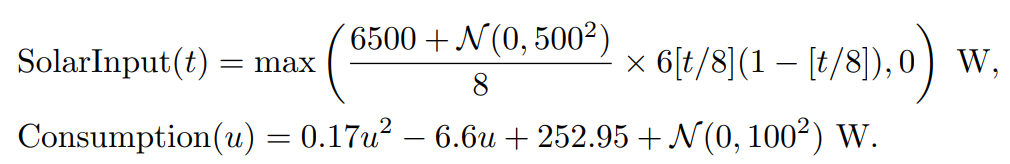



Let me now proceed and compute the solar input and consumption and then resume talking.

In [3]:
def get_solar_input_watts(current_driving_time_h, daily_solar_energy_wh):
  time_fraction = (current_driving_time_h % race_day_hours) / race_day_hours
  power = (daily_solar_energy_wh / race_day_hours) * 6 * time_fraction * (1 - time_fraction)
  return max(0, power)

In [4]:
def get_power_consumption_watts(velocity_kmh):
  base_consumption = 0.17 * velocity_kmh**2 - 6.6 * velocity_kmh + 252.95
  noise = np.random.normal(0, 100)
  return max(0, base_consumption + noise)

The code below is the most crucial bit of the code let me take some time.

We would first define the set of initialization parameters.

Further for every step size that is this bit of code would run again and again and this would calcualte the power in each of the step size.

Note it takes in input as teh velocity which is not yet define which we would show in the below codes.

In [5]:
def run_race(velocity_profile_func):

    driving_time_h = 0.0
    dist_km = 0.0
    battery_wh = initial_battery_wh

    daily_solar_energy = np.random.normal(6500, 500)

    while True:
        # Check for end conditions
        if dist_km >= total_race_distance_km:
            return (True, driving_time_h)
        if driving_time_h >= total_race_hours:
            return (False, total_race_hours)
        if battery_wh < min_safe_battery_wh:
            return (False, total_race_hours)

        # Check for a new day to get a new solar energy value
        if driving_time_h > 0 and (driving_time_h % race_day_hours) < time_step_hours:
             daily_solar_energy = np.random.normal(6500, 500)

        # Calculate energy balance
        solar_watts = get_solar_input_watts(driving_time_h, daily_solar_energy)
        velocity_kmh = velocity_profile_func(driving_time_h)
        consumption_watts = get_power_consumption_watts(velocity_kmh)

        net_power_watts = solar_watts - consumption_watts
        energy_change_wh = net_power_watts * time_step_hours

        battery_wh += energy_change_wh
        battery_wh = min(battery_wh, battery_capacity_wh)

        # Update race state
        dist_km += velocity_kmh * time_step_hours
        driving_time_h += time_step_hours

This is the objective function section of the function this is where we would define the objective and do it's analysis in the code below the function defined would take in inout a vector input with 25 entries from the optimizing method output and test it to predict the probability of completing the race and the probaility of completing the race in that given time T.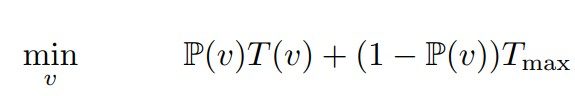

In [6]:
def objective_function(velocity_vector):
    """The function the optimizer tries to minimize."""
    def velocity_profile(driving_hours):
        block_index = int(driving_hours // time_block_hours)
        block_index = min(block_index, len(velocity_vector) - 1)
        return velocity_vector[block_index]

    successful_runs, total_finish_time = 0, 0.0
    for _ in range(n_simulations):
        is_success, finish_time = run_race(velocity_profile)
        if is_success:
            successful_runs += 1
            total_finish_time += finish_time

    p_v = successful_runs / n_simulations
    t_v = total_finish_time / successful_runs if successful_runs > 0 else total_race_hours
    expected_time = p_v * t_v + (1 - p_v) * total_race_hours

    print(f"Testing Avg Vel: {np.mean(velocity_vector):.1f} km/h -> Score: {expected_time:.2f}h")
    return expected_time

In [7]:
def analyze_and_plot(optimal_profile_vector):

    print("\n--- Running Post-Optimization Analysis for Plotting ---")
    velocities_for_plot, objectives_for_plot, probabilities_for_plot = [], [], []

    velocity_range = np.linspace(min_velocity_kmh, max_velocity_kmh, 30)

    for v in velocity_range:
        print(f"Analyzing constant velocity: {v:.1f} km/h...")
        constant_profile_vector = [v] * num_time_blocks
        score = objective_function(constant_profile_vector)

        def temp_profile(h): return v
        successes = sum(1 for _ in range(n_simulations) if run_race(temp_profile)[0])
        prob = successes / n_simulations

        velocities_for_plot.append(v)
        objectives_for_plot.append(score)
        probabilities_for_plot.append(prob)

    # Sort the results to draw a clean, continuous line
    sorted_indices = np.argsort(velocities_for_plot)
    sorted_velocities = np.array(velocities_for_plot)[sorted_indices]
    sorted_objectives = np.array(objectives_for_plot)[sorted_indices]
    sorted_probabilities = np.array(probabilities_for_plot)[sorted_indices]

    # --- PLOTTING ---
    plt.style.use('seaborn-v0_8-whitegrid')

    # Plot 1: Optimal Velocity Strategy Profile
    plt.figure(figsize=(12, 7))
    time_points = np.arange(num_time_blocks + 1) * time_block_hours
    velocities_to_plot = np.append(optimal_profile_vector, optimal_profile_vector[-1])
    plt.step(time_points, velocities_to_plot, where='post', linewidth=2)
    plt.title('Optimal Velocity Strategy', fontsize=16)
    plt.xlabel('Driving Time (hours)', fontsize=12)
    plt.ylabel('Velocity (km/h)', fontsize=12)
    plt.xlim(0, total_race_hours)
    plt.ylim(min_velocity_kmh - 5, max_velocity_kmh + 5)
    plt.grid(True)
    plt.show()

    # Plot 2 & 3: Objective Function and Probability (Now with continuous lines)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    ax1.plot(sorted_velocities, sorted_objectives, linestyle='-', color='royalblue', marker='o', markersize=5, label='Trend')
    ax1.set_title('Objective Function vs. Average Velocity', fontsize=14)
    ax1.set_ylabel('Expected Time (hours)')
    ax1.legend()

    ax2.plot(sorted_velocities, sorted_probabilities, linestyle='-', color='darkgreen', marker='o', markersize=5, label='Trend')
    ax2.set_title('Probability of Finishing vs. Average Velocity', fontsize=14)
    ax2.set_xlabel('Average Velocity (km/h)')
    ax2.set_ylabel('Probability')
    ax2.set_ylim(0, 1.05)
    ax2.legend()

    plt.tight_layout()
    plt.show()

The below code is the main excecution part of the cell :

Before I explain the working of the code let me first explain the optimization technique that is differential evolution.

This technique is inspired from the darwin's theory of natural selection.

Differential Evolution is an optimization algorithm that finds the best solution by maintaining a population of candidate solutions.

For each candidate, it creates a new "trial" solution by taking the weighted difference between two other random candidates and adding it to a third.

The trial solution then competes with the original candidate, and only the one with the better score survives into the next generation, continuously improving the population.

/usr/local/lib/python3.12/dist-packages/scipy/optimize/_differentialevolution.py:487: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


Streaming output truncated to the last 5000 lines.
Testing Avg Vel: 84.3 km/h -> Score: 43.44h
Testing Avg Vel: 80.2 km/h -> Score: 38.46h
Testing Avg Vel: 81.5 km/h -> Score: 38.22h
Testing Avg Vel: 87.7 km/h -> Score: 57.99h
Testing Avg Vel: 87.0 km/h -> Score: 60.00h
Testing Avg Vel: 81.1 km/h -> Score: 49.96h
Testing Avg Vel: 84.1 km/h -> Score: 40.57h
Testing Avg Vel: 83.9 km/h -> Score: 39.75h
Testing Avg Vel: 85.4 km/h -> Score: 37.32h
Testing Avg Vel: 83.4 km/h -> Score: 38.34h
Testing Avg Vel: 84.5 km/h -> Score: 40.53h
Testing Avg Vel: 87.0 km/h -> Score: 58.52h
Testing Avg Vel: 84.4 km/h -> Score: 37.32h
Testing Avg Vel: 83.2 km/h -> Score: 43.76h
Testing Avg Vel: 85.8 km/h -> Score: 37.31h
Testing Avg Vel: 81.3 km/h -> Score: 37.32h
Testing Avg Vel: 82.8 km/h -> Score: 40.33h
Testing Avg Vel: 83.7 km/h -> Score: 37.44h
Testing Avg Vel: 83.2 km/h -> Score: 37.88h
Testing Avg Vel: 80.2 km/h -> Score: 38.04h
Testing Avg Vel: 84.6 km/h -> Score: 41.18h
Testing Avg Vel: 81.6 km/

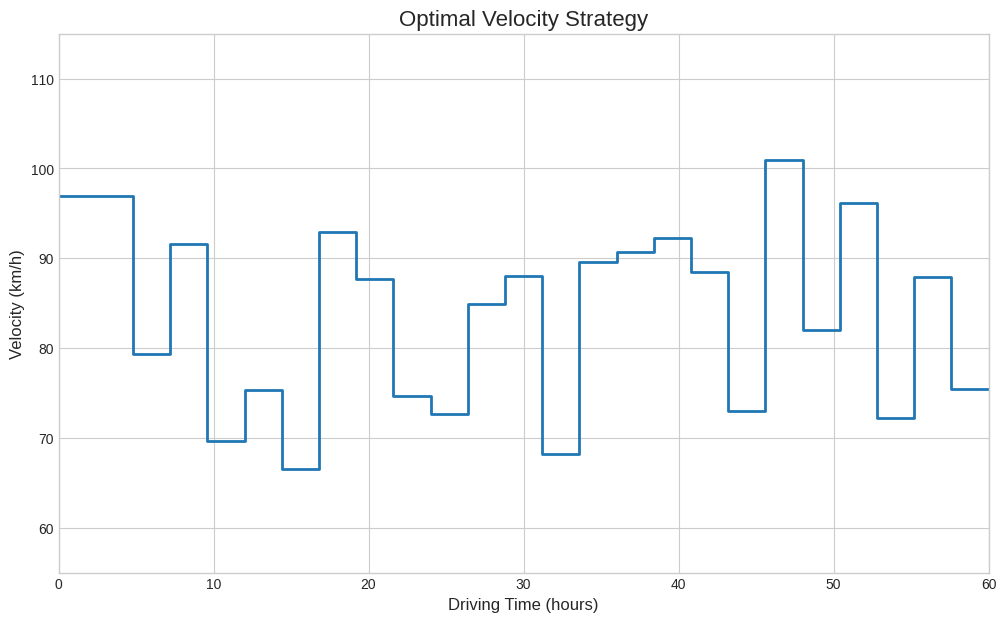

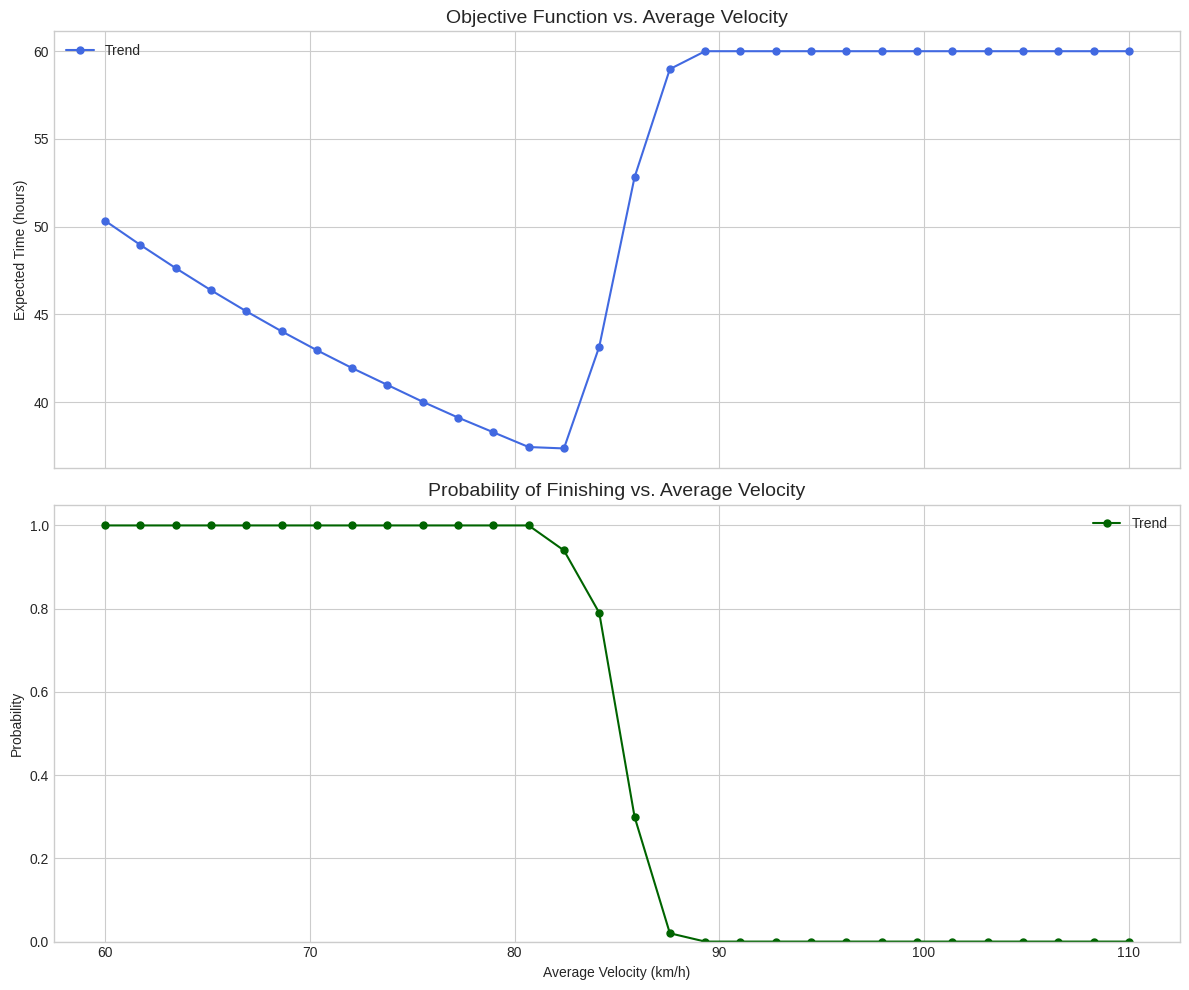

In [8]:
def main():

    start_time = time.time()

    bounds = [(min_velocity_kmh, max_velocity_kmh)] * num_time_blocks

    result = differential_evolution(
        objective_function, bounds,
        strategy='best1bin', maxiter=200, popsize=20, tol=0.01, disp=True,
        workers=-1
    )

    optimization_time = time.time() - start_time
    print(f"\n--- Optimization Complete in {optimization_time:.2f} seconds ---")
    optimal_profile_vector = result.x

    # --- FINAL OPTIMAL VELOCITY OUTPUT ---
    print("\n--- FINAL OPTIMAL STRATEGY ---")
    print(f"Optimal Velocity Profile: {[round(v, 2) for v in optimal_profile_vector]} km/h")
    print(f"Minimum Expected Finishing Time: {result.fun:.2f} hours")

    analyze_and_plot(optimal_profile_vector)

if __name__ == "__main__":
    main()


In the graph it is cleart that the objective function and probability of
finishing depend on this constant velocity. We see that there is a very sharp transition.
where the probability drops from almost 1 to almost 0.